# All-optical control

hello there

In [1]:
import brian2 as b2
from brian2 import np
import cleo
from cleo import opto, imaging

# numpy faster than cython for lightweight example
b2.prefs.codegen.target = 'numpy'
# for reproducibility
rng = np.random.default_rng(92)

cleo.utilities.style_plots_for_docs()

In [2]:
scope = imaging.Scope(
    focus_depth=100 * b2.um,
    img_width=500 * b2.um,
    indicator=imaging.jgcamp7f(),
)


ng = b2.NeuronGroup(
    500,
    """
    dv/dt = (
        -(v - E_L)
        + Delta_T*exp((v-theta)/Delta_T)
        + Rm*(I_exc + I_inh + I_bg)
    ) / tau_m + sigma*sqrt(2/tau_m)*xi: volt
    I_exc : amp
    I_inh : amp
    """,
    threshold="v > -10*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * b2.ms,
        "Rm": 500 * b2.Mohm,
        "theta": -50 * b2.mV,
        "Delta_T": 2 * b2.mV,
        "E_L": -70 * b2.mV,
        "sigma": 5 * b2.mV,
        "I_bg": 60 * b2.pamp,
    },
)
cleo.coords.assign_coords_rand_rect_prism(ng, [-0.2, 0.2], [-0.2, 0.2], [0, 0.4])
sim = cleo.CLSimulator(b2.Network(ng))

TypeError: CalDynamicGECI.__init__() missing 4 required keyword-only arguments: 'snr', 'h_ca_amp', 'h_ca_tau_on', and 'h_ca_tau_off'

By default a scope selects neurons based on focus depth and assigns them a signal-to-noise ratio (SNR) based on soma size.
(Larger cells' SNR decays more slowly with distance from the focal plane.)
`focus_depth` and `soma_size` are taken from scope parameters but can be overridden on injection.

In [ ]:
sim.inject(scope, ng)  # uses scope's parameters
# overrides
sim.inject(scope, ng, focus_depth=200 * b2.um, soma_radius=7 * b2.um)

WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/imaging/scope.py:37: RuntimeWarning: invalid value encountered in sqrt
  r_soma_visible = np.sqrt(soma_radius**2 - perp_distances**2)
 [py.warnings]


CLSimulator(io_processor=None, devices={Scope(brian_objects=set(), sim=..., name='Scope', save_history=True, indicator=Indicator(snr=2, location='cytoplasm', name='Indicator', brian_objects=set()), focus_depth=100. * umetre, img_width=0.5 * mmetre, location=array([0., 0., 0.]) * metre, direction=array([0., 0., 1.]), soma_radius=10. * umetre, snr_cutoff=1)})

While Cleo adjusts SNR according to distance from the focal plane automatically, other SNR adjustments can be made manually by calling {meth}`~cleo.imaging.Scope.target_neurons_in_plane` to reflect factors such as heterogeneous soma sizes or indicator expression or reduced SNR with depth.

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

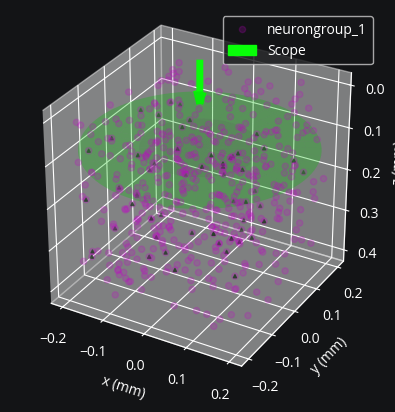

In [ ]:
i_targets, snr_focus_factor = scope.target_neurons_in_plane(ng, focus_depth=300 * b2.um)
# scale SNR randomly to simulate biological variability
snr = scope.indicator.snr * snr_focus_factor * rng.normal(1, .2, len(i_targets))
sim.inject(scope, ng, focus_depth=None, i_targets=i_targets, snr=snr)

cleo.viz.plot(ng, colors=['#c500cc'], sim=sim)

In [ ]:
from cleo.imaging import Scope
scope.focus_depth = 200 * b2.um
scope.img_width = 300 * b2.um
scope.direction = [0, 0, 1]
cleo.viz.plot(ng, colors=['#c500cc'], sim=sim)


ImportError: cannot import name 'LightDependentDevice' from partially initialized module 'cleo.light' (most likely due to a circular import) (/home/kyle/Dropbox (GaTech)/projects/cleo/cleo/light/__init__.py)

When `focus_depth` is set to `None`, corresponding to [sculpted holographic imaging](https://www.sciencedirect.com/science/article/pii/S0959438817301940), the scope will select all neurons in the volume, or the user can specify a list of neurons to select via `i_targets` on injection.

## Opsin
We couldn't find data, so we'll make it up...

In [ ]:
opsin = opto.vfchrimson_4s()
opsin.spectrum.append((1050, .05))
